# Import required libraries

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

In [2]:
torch.manual_seed(24)
np.random.seed(24)

# Import Dataset

In [3]:
dataset = pd.read_csv('HW2_data/international_matches.csv')
dataset.tail(10)

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
23911,2022-06-14,Ukraine,Republic of Ireland,Europe,Europe,27,47,1535,1449,1,...,No,Draw,75.0,75.0,74.8,78.7,80.0,76.5,72.7,73.8
23912,2022-06-14,Bosnia and Herzegovina,Finland,Europe,Europe,59,57,1388,1406,3,...,No,Win,76.0,83.0,74.2,77.0,78.0,70.0,72.3,73.5
23913,2022-06-14,Romania,Montenegro,Europe,Europe,48,70,1446,1342,0,...,No,Lose,77.0,65.0,73.5,73.7,75.0,76.2,74.7,68.2
23914,2022-06-14,Luxembourg,Faroe Islands,Europe,Europe,94,124,1229,1137,2,...,No,Draw,69.0,NaN,68.5,NaN,69.8,NaN,NaN,NaN
23915,2022-06-14,Turkey,Lithuania,Europe,Europe,43,138,1461,1092,2,...,No,Win,79.0,71.0,78.2,76.7,78.2,NaN,NaN,NaN
23916,2022-06-14,Moldova,Andorra,Europe,Europe,180,153,932,1040,2,...,No,Win,65.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23917,2022-06-14,Liechtenstein,Latvia,Europe,Europe,192,135,895,1105,0,...,No,Lose,NaN,65.0,NaN,NaN,NaN,NaN,NaN,NaN
23918,2022-06-14,Chile,Ghana,South America,Africa,28,60,1526,1387,0,...,Yes,Lose,79.0,74.0,75.5,76.7,78.2,75.5,76.0,78.2
23919,2022-06-14,Japan,Tunisia,Asia,Africa,23,35,1553,1499,0,...,No,Lose,73.0,NaN,75.2,75.0,77.5,70.8,72.3,74.0
23920,2022-06-14,Korea Republic,Egypt,Asia,Africa,29,32,1519,1500,4,...,No,Win,75.0,NaN,73.0,80.0,73.8,NaN,79.3,70.8


# Data Preprocessing and Exploratory Data Analysis

Plotting results of matches based on `home_team_fifa_rank` and `away_team_fifa_rank`:

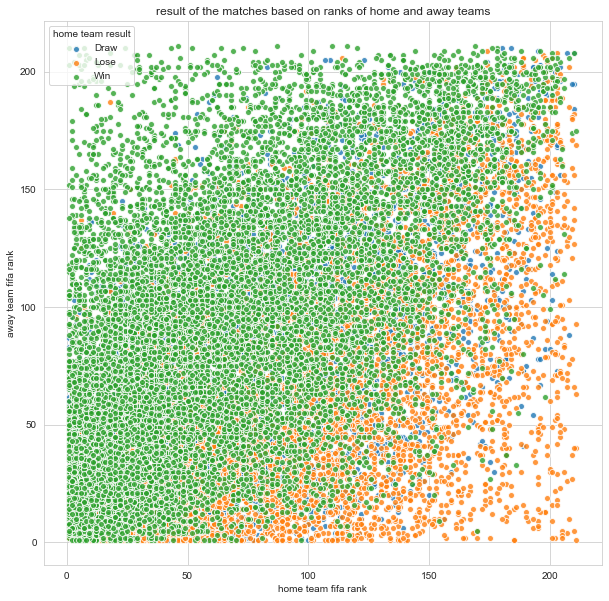

In [4]:
plt.figure(figsize=(10, 10))
for result, result_df in dataset.groupby('home_team_result'):
    plt.scatter(x=result_df['home_team_fifa_rank'], y=result_df['away_team_fifa_rank'], label=result, alpha=0.8,
                edgecolors='white')
plt.legend(title='home team result')
plt.title('result of the matches based on ranks of home and away teams')
plt.xlabel('home team fifa rank')
plt.ylabel('away team fifa rank')
plt.show()

It's a good plot! But seaborns does a better job at scatterplots by jittering the points a little, such that overlapping minimize number of overlapping points.

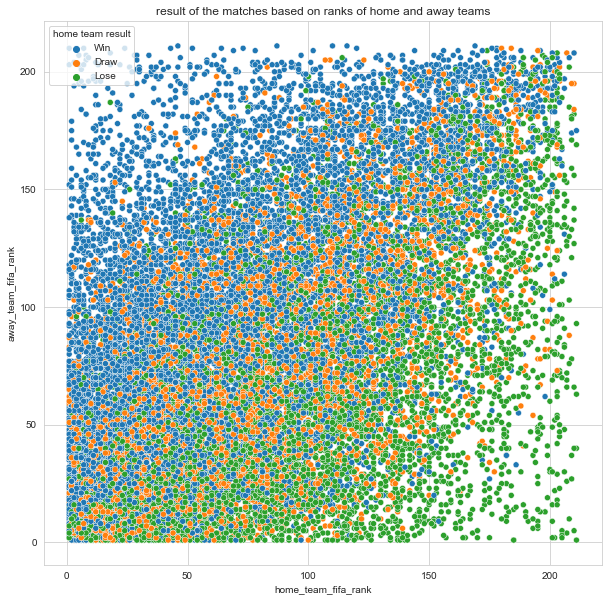

In [5]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data=dataset, x='home_team_fifa_rank', y='away_team_fifa_rank', hue='home_team_result')
plt.title('result of the matches based on ranks of home and away teams')
plt.legend(title='home team result')
plt.show()

## Cleaning Data

In [6]:
(dataset == 0).any()

date                             False
home_team                        False
away_team                        False
home_team_continent              False
away_team_continent              False
home_team_fifa_rank              False
away_team_fifa_rank              False
home_team_total_fifa_points       True
away_team_total_fifa_points       True
home_team_score                   True
away_team_score                   True
tournament                       False
city                             False
country                          False
neutral_location                  True
shoot_out                        False
home_team_result                 False
home_team_goalkeeper_score       False
away_team_goalkeeper_score       False
home_team_mean_defense_score     False
home_team_mean_offense_score     False
home_team_mean_midfield_score    False
away_team_mean_defense_score     False
away_team_mean_offense_score     False
away_team_mean_midfield_score    False
dtype: bool

There are invalid zero scores `home_team_total_fifa_points`, and `away_team_total_fifa_points` columns.

In [7]:
dataset.isna().any()

date                             False
home_team                        False
away_team                        False
home_team_continent              False
away_team_continent              False
home_team_fifa_rank              False
away_team_fifa_rank              False
home_team_total_fifa_points      False
away_team_total_fifa_points      False
home_team_score                  False
away_team_score                  False
tournament                       False
city                             False
country                          False
neutral_location                 False
shoot_out                        False
home_team_result                 False
home_team_goalkeeper_score        True
away_team_goalkeeper_score        True
home_team_mean_defense_score      True
home_team_mean_offense_score      True
home_team_mean_midfield_score     True
away_team_mean_defense_score      True
away_team_mean_offense_score      True
away_team_mean_midfield_score     True
dtype: bool

There isn't any `NaN` values in the columns that we are going to train on.

Removing zero values in the mentioned columns:

In [8]:
valid_rows = ~(dataset[['home_team_total_fifa_points', 'away_team_total_fifa_points']] == 0).any(axis=1)
dataset = dataset[valid_rows]
dataset.head()

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
14250,2011-08-24,Guyana,India,South America,Asia,114,158,260,112,2,...,No,Win,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14251,2011-08-24,Thailand,Singapore,Asia,Asia,120,129,245,208,0,...,No,Draw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14252,2011-08-25,United Arab Emirates,Qatar,Asia,Asia,108,88,298,364,3,...,No,Win,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14253,2011-08-26,Bahrain,Sudan,Asia,Africa,101,98,325,328,1,...,No,Win,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14254,2011-08-27,Angola,Congo DR,Africa,Africa,96,127,338,221,1,...,No,Lose,70.0,NaN,NaN,69.7,61.5,69.2,69.7,70.0


Selecting training features:

In [9]:
training_features = ['home_team_fifa_rank', 'away_team_fifa_rank', 'home_team_total_fifa_points',
                     'away_team_total_fifa_points', 'home_team_result']
dataset = dataset[training_features]
dataset.shape

(9594, 5)

Converting result of game to numeric values (0, 1, 2):

In [10]:
dataset.home_team_result.unique()

array(['Win', 'Draw', 'Lose'], dtype=object)

In [11]:
label_to_idx = {'Win': 2, 'Draw': 1, 'Lose': 0}
idx_to_label = {v: k for k, v in label_to_idx.items()}
print(label_to_idx)
print(idx_to_label)

{'Win': 2, 'Draw': 1, 'Lose': 0}
{2: 'Win', 1: 'Draw', 0: 'Lose'}


In [12]:
dataset['home_team_result'] = dataset['home_team_result'].map(label_to_idx)
dataset.head()

,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_result
14250,114,158,260,112,2
14251,120,129,245,208,1
14252,108,88,298,364,2
14253,101,98,325,328,2
14254,96,127,338,221,0


## Splitting Dataset

In [13]:
num_train = int(0.75 * len(dataset))
# shuffling dataframe
dataset = dataset.sample(frac=1)
train_df = dataset.iloc[:num_train]
test_df = dataset.iloc[num_train:]
train_df.shape, test_df.shape

((7195, 5), (2399, 5))

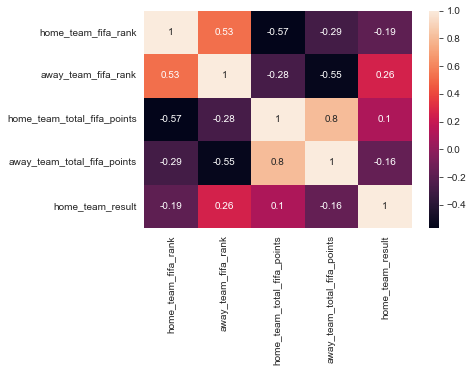

In [14]:
sns.heatmap(train_df.corr(), annot=True)
plt.show()

# Dataset and Dataloaders

In [15]:
class SoccerDataset(torch.utils.data.Dataset):

    def __init__(self, df: pd.DataFrame, target):
        self.features = torch.tensor(df.drop(columns=[target]).to_numpy()).type(torch.FloatTensor)
        self.target = torch.tensor(df[target].to_numpy()).type(torch.LongTensor)

    def __len__(self):
        return len(self.target)

    def __getitem__(self, item):
        x = self.features[item]
        y = self.target[item]
        return x, y

In [16]:
train_set = SoccerDataset(train_df, 'home_team_result')
test_set = SoccerDataset(test_df, 'home_team_result')

In [17]:
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
test_loader = DataLoader(test_set, batch_size=256, shuffle=True)

# Defining Model

In [18]:
class SoccerPredictor(nn.Module):

    def __init__(self, layers_shape, dropout=False):
        super().__init__()
        layers = []
        for shape in layers_shape[:-1]:
            layers.append(nn.Linear(*shape))
            layers.append(nn.ReLU())
            if dropout:
                layers.append(nn.Dropout(dropout))
        layers.append(nn.Linear(*layers_shape[-1]))
        self.layers = nn.Sequential(*layers)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        return self.layers(x)

    def get_probabilities(self, x):
        with torch.no_grad():
            return self.softmax(self.forward(x))

In [19]:
in_features = train_df.shape[1] - 1
layers_shape = [
    (in_features, 10),
    (10, 20),
    (20, 8),
    (8, 3)
]
model = SoccerPredictor(layers_shape)
model

SoccerPredictor(
  (layers): Sequential(
    (0): Linear(in_features=4, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=3, bias=True)
  )
  (softmax): Softmax(dim=-1)
)

# Training Model

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
def accuracy(y_pred: np.ndarray, y_true: np.ndarray):
    return (y_true == y_pred).mean()

In [22]:
def one_epoch(model, loader, criterion, optimizer=None, epoch=None, train=True, set_name='Train'):
    total_loss = 0
    N = len(loader.dataset)
    Y = []
    Y_pred = []
    if train:
        model.train()
    else:
        model.eval()

    with torch.set_grad_enabled(train), tqdm.tqdm(enumerate(loader)) as pbar:
        for i, (x, y) in pbar:
            if train:
                optimizer.zero_grad()

            x = x.to(device)
            y = y.to(device)
            p = model(x)

            loss = criterion(p, y)

            total_loss += loss.item() * len(x)
            pbar.set_description(f'{epoch}: {set_name} Loss: {total_loss / N:.3e}')
            if train:
                loss.backward()
                optimizer.step()

            y_pred = p.argmax(dim=-1)
            Y.append(y.cpu().numpy())
            Y_pred.append(y_pred.cpu().numpy())

    total_loss /= N

    Y = np.concatenate(Y)
    Y_pred = np.concatenate(Y_pred)
    acc = accuracy(Y_pred, Y)
    print(f'Accuracy of {set_name} set: {acc}')
    return total_loss, acc

In [23]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [24]:
def train_model(model, dataloaders, num_epochs, criterion, optimizer):
    train_loader, test_loader = dataloaders

    for epoch in range(num_epochs):
        train_loss, train_acc = one_epoch(model, train_loader, criterion, optimizer, epoch, train=True, set_name='Train')
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        test_loss, test_acc = one_epoch(model, test_loader, criterion, epoch=epoch, train=False, set_name='Test')
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
        print('\n', '-' * 60)

    plt.plot(train_losses, label='train')
    plt.plot(test_losses, label='test')
    plt.title('loss history of training and test sets')
    plt.legend()
    plt.show()

    plt.plot(train_accuracies, label='train')
    plt.plot(test_accuracies, label='test')
    plt.title('Accuracy history of training and test sets')
    plt.legend()
    plt.show()

Training config:

In [25]:
lr = 0.001
model2 = SoccerPredictor(layers_shape).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=lr)

0: Train Loss: 4.260e+00: : 29it [00:00, 205.02it/s]


Accuracy of Train set: 0.31160528144544825


0: Test Loss: 1.398e+00: : 10it [00:00, 319.99it/s]


Accuracy of Test set: 0.4701959149645686

 ------------------------------------------------------------


1: Train Loss: 1.203e+00: : 29it [00:00, 264.14it/s]


Accuracy of Train set: 0.47588603196664353


1: Test Loss: 1.035e+00: : 10it [00:00, 264.90it/s]


Accuracy of Test set: 0.5560650270946228

 ------------------------------------------------------------


2: Train Loss: 1.055e+00: : 29it [00:00, 174.56it/s]


Accuracy of Train set: 0.5473245309242529


2: Test Loss: 9.753e-01: : 10it [00:00, 291.95it/s]


Accuracy of Test set: 0.5623176323468112

 ------------------------------------------------------------


3: Train Loss: 9.925e-01: : 29it [00:00, 270.68it/s]


Accuracy of Train set: 0.5589993050729674


3: Test Loss: 9.453e-01: : 10it [00:00, 192.38it/s]


Accuracy of Test set: 0.5585660691954981

 ------------------------------------------------------------


4: Train Loss: 9.668e-01: : 29it [00:00, 263.14it/s]


Accuracy of Train set: 0.5638637943015984


4: Test Loss: 9.354e-01: : 10it [00:00, 321.18it/s]


Accuracy of Test set: 0.5610671112963735

 ------------------------------------------------------------


5: Train Loss: 9.580e-01: : 29it [00:00, 275.74it/s]


Accuracy of Train set: 0.5652536483669215


5: Test Loss: 9.378e-01: : 10it [00:00, 640.18it/s]


Accuracy of Test set: 0.578991246352647

 ------------------------------------------------------------


6: Train Loss: 9.527e-01: : 29it [00:00, 205.69it/s]


Accuracy of Train set: 0.5640027797081306


6: Test Loss: 9.470e-01: : 10it [00:00, 316.03it/s]


Accuracy of Test set: 0.5689870779491455

 ------------------------------------------------------------


7: Train Loss: 9.484e-01: : 29it [00:00, 231.73it/s]


Accuracy of Train set: 0.5676164002779708


7: Test Loss: 9.294e-01: : 10it [00:00, 638.49it/s]


Accuracy of Test set: 0.5619007919966653

 ------------------------------------------------------------


8: Train Loss: 9.481e-01: : 29it [00:00, 261.44it/s]


Accuracy of Train set: 0.5678943710910355


8: Test Loss: 9.336e-01: : 10it [00:00, 315.65it/s]


Accuracy of Test set: 0.5744060025010421

 ------------------------------------------------------------


9: Train Loss: 9.468e-01: : 29it [00:00, 215.04it/s]


Accuracy of Train set: 0.5660875608061153


9: Test Loss: 9.212e-01: : 10it [00:00, 392.39it/s]


Accuracy of Test set: 0.5764902042517716

 ------------------------------------------------------------


10: Train Loss: 9.452e-01: : 29it [00:00, 264.16it/s]


Accuracy of Train set: 0.5652536483669215


10: Test Loss: 9.392e-01: : 10it [00:00, 316.11it/s]


Accuracy of Test set: 0.5681533972488537

 ------------------------------------------------------------


11: Train Loss: 9.446e-01: : 29it [00:00, 264.03it/s]


Accuracy of Train set: 0.5630298818624044


11: Test Loss: 9.176e-01: : 10it [00:00, 640.16it/s]


Accuracy of Test set: 0.5664860358482701

 ------------------------------------------------------------


12: Train Loss: 9.407e-01: : 29it [00:00, 261.06it/s]


Accuracy of Train set: 0.5692842251563586


12: Test Loss: 9.212e-01: : 10it [00:00, 320.06it/s]


Accuracy of Test set: 0.5756565235514798

 ------------------------------------------------------------


13: Train Loss: 9.408e-01: : 29it [00:00, 235.04it/s]


Accuracy of Train set: 0.5697011813759555


13: Test Loss: 9.193e-01: : 10it [00:00, 318.07it/s]


Accuracy of Test set: 0.5785744060025011

 ------------------------------------------------------------


14: Train Loss: 9.419e-01: : 29it [00:00, 264.24it/s]


Accuracy of Train set: 0.5683113273106324


14: Test Loss: 9.149e-01: : 10it [00:00, 640.17it/s]


Accuracy of Test set: 0.5739891621508962

 ------------------------------------------------------------


15: Train Loss: 9.443e-01: : 29it [00:00, 228.60it/s]


Accuracy of Train set: 0.568589298123697


15: Test Loss: 9.173e-01: : 10it [00:00, 320.02it/s]


Accuracy of Test set: 0.5689870779491455

 ------------------------------------------------------------


16: Train Loss: 9.452e-01: : 29it [00:00, 264.11it/s]


Accuracy of Train set: 0.5676164002779708


16: Test Loss: 9.144e-01: : 10it [00:00, 320.47it/s]


Accuracy of Test set: 0.5752396832013339

 ------------------------------------------------------------


17: Train Loss: 9.393e-01: : 29it [00:00, 254.64it/s]


Accuracy of Train set: 0.5701181375955525


17: Test Loss: 9.154e-01: : 10it [00:00, 160.02it/s]


Accuracy of Test set: 0.5739891621508962

 ------------------------------------------------------------


18: Train Loss: 9.407e-01: : 29it [00:00, 264.15it/s]


Accuracy of Train set: 0.5694232105628909


18: Test Loss: 9.249e-01: : 10it [00:00, 315.96it/s]


Accuracy of Test set: 0.5781575656523551

 ------------------------------------------------------------


19: Train Loss: 9.494e-01: : 29it [00:00, 231.17it/s]


Accuracy of Train set: 0.5660875608061153


19: Test Loss: 9.182e-01: : 10it [00:00, 597.80it/s]


Accuracy of Test set: 0.5694039182992914

 ------------------------------------------------------------


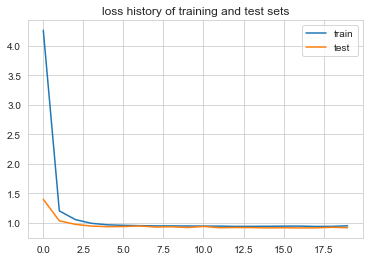

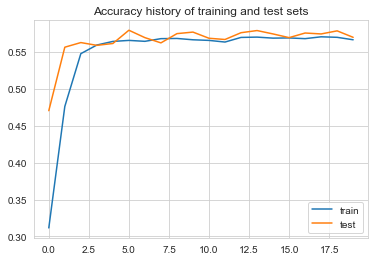

In [26]:
train_losses.clear()
test_losses.clear()
train_accuracies.clear()
test_accuracies.clear()
train_model(model2, [train_loader, test_loader], 20, criterion, optimizer)

In [27]:
print(f'Final test accuracy: {test_accuracies[-1]}')

Final test accuracy: 0.5694039182992914


We've reached the desired accuracy already. But we can test wider or deeper networks with dropout too:

In [28]:
from more_itertools import pairwise
layers_shape = list(pairwise([in_features, 32, 32, 32, 32, 32, 3]))
layers_shape

[(4, 32), (32, 32), (32, 32), (32, 32), (32, 32), (32, 3)]

In [29]:
lr = 3e-3
model = SoccerPredictor(layers_shape, dropout=0.3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

0: Train Loss: 1.674e+00: : 29it [00:00, 167.92it/s]


Accuracy of Train set: 0.3852675469075747


0: Test Loss: 1.098e+00: : 10it [00:00, 320.49it/s]


Accuracy of Test set: 0.3055439766569404

 ------------------------------------------------------------


1: Train Loss: 1.076e+00: : 29it [00:00, 192.47it/s]


Accuracy of Train set: 0.4589298123697012


1: Test Loss: 1.074e+00: : 10it [00:00, 320.01it/s]


Accuracy of Test set: 0.49395581492288454

 ------------------------------------------------------------


2: Train Loss: 1.059e+00: : 29it [00:00, 205.69it/s]


Accuracy of Train set: 0.4790826963168867


2: Test Loss: 1.056e+00: : 10it [00:00, 316.05it/s]


Accuracy of Test set: 0.49395581492288454

 ------------------------------------------------------------


3: Train Loss: 1.044e+00: : 29it [00:00, 185.11it/s]


Accuracy of Train set: 0.4846421125781793


3: Test Loss: 1.035e+00: : 10it [00:00, 640.24it/s]


Accuracy of Test set: 0.49395581492288454

 ------------------------------------------------------------


4: Train Loss: 1.027e+00: : 29it [00:00, 230.51it/s]


Accuracy of Train set: 0.4985406532314107


4: Test Loss: 1.000e+00: : 10it [00:00, 320.06it/s]


Accuracy of Test set: 0.554814506044185

 ------------------------------------------------------------


5: Train Loss: 1.015e+00: : 29it [00:00, 184.56it/s]


Accuracy of Train set: 0.512856150104239


5: Test Loss: 9.915e-01: : 10it [00:00, 320.01it/s]


Accuracy of Test set: 0.5656523551479783

 ------------------------------------------------------------


6: Train Loss: 1.009e+00: : 29it [00:00, 203.89it/s]


Accuracy of Train set: 0.5120222376650452


6: Test Loss: 9.800e-01: : 10it [00:00, 496.14it/s]


Accuracy of Test set: 0.5719049604001667

 ------------------------------------------------------------


7: Train Loss: 9.967e-01: : 29it [00:00, 231.15it/s]


Accuracy of Train set: 0.5317581653926338


7: Test Loss: 9.806e-01: : 10it [00:00, 638.50it/s]


Accuracy of Test set: 0.570654439349729

 ------------------------------------------------------------


8: Train Loss: 9.961e-01: : 29it [00:00, 184.56it/s]


Accuracy of Train set: 0.5346768589298123


8: Test Loss: 9.660e-01: : 10it [00:00, 320.06it/s]


Accuracy of Test set: 0.5702375989995832

 ------------------------------------------------------------


9: Train Loss: 9.882e-01: : 29it [00:00, 184.70it/s]


Accuracy of Train set: 0.5378735232800556


9: Test Loss: 9.609e-01: : 10it [00:00, 315.84it/s]


Accuracy of Test set: 0.567319716548562

 ------------------------------------------------------------


10: Train Loss: 9.846e-01: : 29it [00:00, 221.55it/s]


Accuracy of Train set: 0.5457956914523975


10: Test Loss: 9.700e-01: : 10it [00:00, 127.73it/s]


Accuracy of Test set: 0.5694039182992914

 ------------------------------------------------------------


11: Train Loss: 9.772e-01: : 29it [00:00, 205.60it/s]


Accuracy of Train set: 0.5480194579569145


11: Test Loss: 9.824e-01: : 10it [00:00, 640.12it/s]


Accuracy of Test set: 0.5464776990412672

 ------------------------------------------------------------


12: Train Loss: 9.775e-01: : 29it [00:00, 184.70it/s]


Accuracy of Train set: 0.5462126476719944


12: Test Loss: 9.713e-01: : 10it [00:00, 320.08it/s]


Accuracy of Test set: 0.570654439349729

 ------------------------------------------------------------


13: Train Loss: 9.722e-01: : 29it [00:00, 184.69it/s]


Accuracy of Train set: 0.5520500347463516


13: Test Loss: 9.713e-01: : 10it [00:00, 319.91it/s]


Accuracy of Test set: 0.5773238849520633

 ------------------------------------------------------------


14: Train Loss: 9.720e-01: : 29it [00:00, 204.09it/s]


Accuracy of Train set: 0.5538568450312717


14: Test Loss: 9.729e-01: : 10it [00:00, 316.04it/s]


Accuracy of Test set: 0.5752396832013339

 ------------------------------------------------------------


15: Train Loss: 9.677e-01: : 29it [00:00, 231.31it/s]


Accuracy of Train set: 0.5491313412091731


15: Test Loss: 9.706e-01: : 10it [00:00, 320.09it/s]


Accuracy of Test set: 0.5702375989995832

 ------------------------------------------------------------


16: Train Loss: 9.670e-01: : 29it [00:00, 184.92it/s]


Accuracy of Train set: 0.551772063933287


16: Test Loss: 9.713e-01: : 10it [00:00, 640.16it/s]


Accuracy of Test set: 0.5781575656523551

 ------------------------------------------------------------


17: Train Loss: 9.651e-01: : 29it [00:00, 222.22it/s]


Accuracy of Train set: 0.5595552466990966


17: Test Loss: 9.682e-01: : 10it [00:00, 326.37it/s]


Accuracy of Test set: 0.5744060025010421

 ------------------------------------------------------------


18: Train Loss: 9.624e-01: : 29it [00:00, 185.90it/s]


Accuracy of Train set: 0.5609451007644197


18: Test Loss: 9.649e-01: : 10it [00:00, 314.89it/s]


Accuracy of Test set: 0.574822842851188

 ------------------------------------------------------------


19: Train Loss: 9.622e-01: : 29it [00:00, 205.73it/s]


Accuracy of Train set: 0.5556636553161918


19: Test Loss: 9.602e-01: : 10it [00:00, 320.10it/s]


Accuracy of Test set: 0.5744060025010421

 ------------------------------------------------------------


20: Train Loss: 9.642e-01: : 29it [00:00, 209.23it/s]


Accuracy of Train set: 0.5551077136900625


20: Test Loss: 9.639e-01: : 10it [00:00, 320.11it/s]


Accuracy of Test set: 0.5773238849520633

 ------------------------------------------------------------


21: Train Loss: 9.700e-01: : 29it [00:00, 204.92it/s]


Accuracy of Train set: 0.5523280055594163


21: Test Loss: 9.735e-01: : 10it [00:00, 318.18it/s]


Accuracy of Test set: 0.5644018340975406

 ------------------------------------------------------------


22: Train Loss: 9.618e-01: : 29it [00:00, 205.32it/s]


Accuracy of Train set: 0.5584433634468381


22: Test Loss: 9.473e-01: : 10it [00:00, 644.80it/s]


Accuracy of Test set: 0.5764902042517716

 ------------------------------------------------------------


23: Train Loss: 9.584e-01: : 29it [00:00, 231.23it/s]


Accuracy of Train set: 0.5619179986101459


23: Test Loss: 9.615e-01: : 10it [00:00, 228.33it/s]


Accuracy of Test set: 0.5656523551479783

 ------------------------------------------------------------


24: Train Loss: 9.569e-01: : 29it [00:00, 200.41it/s]


Accuracy of Train set: 0.5605281445448228


24: Test Loss: 9.643e-01: : 10it [00:00, 319.20it/s]


Accuracy of Test set: 0.5794080867027929

 ------------------------------------------------------------


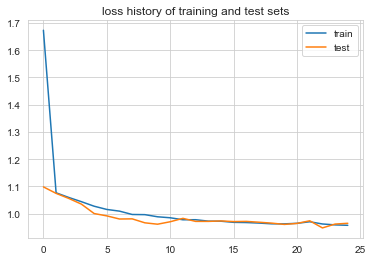

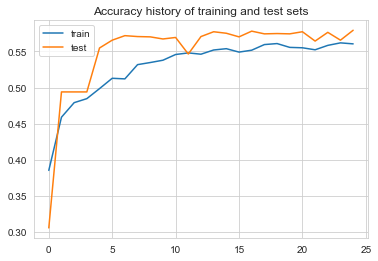

In [30]:
train_losses.clear()
test_losses.clear()
train_accuracies.clear()
test_accuracies.clear()
train_model(model, [train_loader, test_loader], 25, criterion, optimizer)

In [31]:
print(f'Final test accuracy: {test_accuracies[-1]}')

Final test accuracy: 0.5794080867027929


We'll use the first model anyway :)

In [70]:
def get_x(home_rank, home_points, away_rank, away_points):
    return torch.tensor([home_rank, away_rank, home_points, away_points], device=device).type(torch.FloatTensor).view(1, -1)

def match(home, away, model, iran_away=False):
    x = get_x(*home, *away)
    p = model.get_probabilities(x).view(-1).cpu().numpy()
    # changing results to be for iran!
    if iran_away:
        p = p[::-1]
    for i, prob in enumerate(p):
        print(f'{idx_to_label[i]} probability: {prob}')
    result = np.argmax(p)
    print(f'Predicted result: {idx_to_label[result]}')

In [71]:
# rank, total_points
teams = {
    'Iran': (20, 1564.61),
    'USA': (16, 1627.48),
    'England': (5, 1728.47),
    'Wales': (19, 1564)
}

In [72]:
def match_with_iran(teams, model):
    iran = teams.pop('Iran')
    print(f'Considering iran HOME:')
    for country, points in teams.items():
        print(f'**Matching Iran with {country}**')
        match(iran, points, model)
        print()
    print()
    print(f'Considering iran AWAY (note: results are shown for Iran):')
    for country, points in teams.items():
        print(f'**Matching Iran with {country}**')
        match(points, iran, model)
        print()

In [73]:
match_with_iran(teams, model)

Considering iran HOME:
**Matching Iran with USA**
Lose probability: 0.3537098467350006
Draw probability: 0.26569420099258423
Win probability: 0.38059595227241516
Predicted result: Win

**Matching Iran with England**
Lose probability: 0.3829074501991272
Draw probability: 0.27100977301597595
Win probability: 0.34608274698257446
Predicted result: Lose

**Matching Iran with Wales**
Lose probability: 0.33168184757232666
Draw probability: 0.2607609033584595
Win probability: 0.40755724906921387
Predicted result: Win


Considering iran AWAY (note: results are shown for Iran):
**Matching Iran with USA**
Lose probability: 0.2958148717880249
Draw probability: 0.25021231174468994
Win probability: 0.45397281646728516
Predicted result: Win

**Matching Iran with England**
Lose probability: 0.24191996455192566
Draw probability: 0.24308614432811737
Win probability: 0.5149939060211182
Predicted result: Win

**Matching Iran with Wales**
Lose probability: 0.33178120851516724
Draw probability: 0.2608351707

Yey!